# Template Matching Chord Recognition, *Francesco Maccarini*

## Project for the *Audio Signals* course @ Polimi

In this notebook we aim at providing a python implementation of the chord recognition algorithm based on template matching, as presented in: "Müller, Meinard. (2015). *Fundamentals of Music Processing.* 10.1007/978-3-319-21945-5."

### Introduction

We start by constructing the templates for major and minor triads. In chroma representation, every chord is characterized by a 1 in correspndence to those notes that are present in the chord and a 0 in correspondence to those notes that are not present in the chord.

Remember that chroma values are mapped to notes as 
\[ C, C#, D, D#, E, F, F#, G, G#, A, A#, B \]

***

**Example:** C major chord is composed by the notes C, E and G so its chorma representation will be \[ 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0 \]

In [1]:
major_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
minor_labs=["C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
dominant7_labs=["C:7","C#:7","D:7","D#:7","E:7","F:7","F#:7","G:7","G#:7","A:7","A#:7","B:7"]
major7_labs=["C:7+","C#:7+","D:7+","D#:7+","E:7+","F:7+","F#:7+","G:7+","G#:7+","A:7+","A#:7+","B:7+"]
minor7_labs=["C:min7","C#:min7","D:min7","D#:min7","E:min7","F:min7","F#:min7","G:min7","G#:min7","A:min7","A#:min7","B:min7"]

chords_labs=major_labs+minor_labs+dominant7_labs#+major7_labs+minor7_labs

chroma_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

print("Major triads:")
print(major_labs)
print("Minor triads:")
print(minor_labs)
print("Major7 triads:")
print(dominant7_labs)
print("Major7 triads:")
print(major7_labs)
print("Minor7 triads:")
print(minor7_labs)
print("Labels for possible chords:")
print(chords_labs)

print("Chroma values (notes):")
print(chroma_labs)

Major triads:
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
Minor triads:
['C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min', 'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min']
Major7 triads:
['C:7', 'C#:7', 'D:7', 'D#:7', 'E:7', 'F:7', 'F#:7', 'G:7', 'G#:7', 'A:7', 'A#:7', 'B:7']
Major7 triads:
['C:7+', 'C#:7+', 'D:7+', 'D#:7+', 'E:7+', 'F:7+', 'F#:7+', 'G:7+', 'G#:7+', 'A:7+', 'A#:7+', 'B:7+']
Minor7 triads:
['C:min7', 'C#:min7', 'D:min7', 'D#:min7', 'E:min7', 'F:min7', 'F#:min7', 'G:min7', 'G#:min7', 'A:min7', 'A#:min7', 'B:min7']
Labels for possible chords:
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min', 'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min', 'C:7', 'C#:7', 'D:7', 'D#:7', 'E:7', 'F:7', 'F#:7', 'G:7', 'G#:7', 'A:7', 'A#:7', 'B:7']
Chroma values (notes):
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']


In [2]:
import numpy as np

In [8]:
#create chroma templates for chords
major_chords=np.zeros(shape=(12,12))
minor_chords=np.zeros(shape=(12,12))
dominant7_chords=np.zeros(shape=(12,12))
major7_chords=np.zeros(shape=(12,12))
minor7_chords=np.zeros(shape=(12,12))

for i in range(12): #loop on possible triads
    major_chords[(0+i)%12,i]=1
    major_chords[(4+i)%12,i]=1
    major_chords[(7+i)%12,i]=1
    
    minor_chords[(0+i)%12,i]=1
    minor_chords[(3+i)%12,i]=1
    minor_chords[(7+i)%12,i]=1
    
    dominant7_chords[(0+i)%12,i]=1
    dominant7_chords[(4+i)%12,i]=1
    dominant7_chords[(7+i)%12,i]=1
    dominant7_chords[(10+i)%12,i]=1
    
#    major7_chords[(0+i)%12,i]=1
#    major7_chords[(4+i)%12,i]=1
#    major7_chords[(7+i)%12,i]=1
#    major7_chords[(11+i)%12,i]=1
    
#    minor7_chords[(0+i)%12,i]=1
#    minor7_chords[(3+i)%12,i]=1
#    minor7_chords[(7+i)%12,i]=1
#    minor7_chords[(10+i)%12,i]=1

#chords=np.concatenate((major_chords,minor_chords,dominant7_chords,major7_chords,minor7_chords),axis=1)
chords=np.concatenate((major_chords,minor_chords,dominant7_chords),axis=1)
#print(chords)

In [12]:
def normalize_2(chroma):
    #for i in range(chroma.shape[1]):
    #    chroma[:,i]=chroma[:,i]/np.sqrt(sum(chroma[:,i]**2))
    chroma=chroma/np.sqrt(np.sum(chroma**2,axis=0))
    return chroma

chords=normalize_2(chords)

In [13]:
import matplotlib.pyplot as plt
import librosa.display as dspl

Text(0.5, 1.0, 'Chroma representation of major and minor triads')

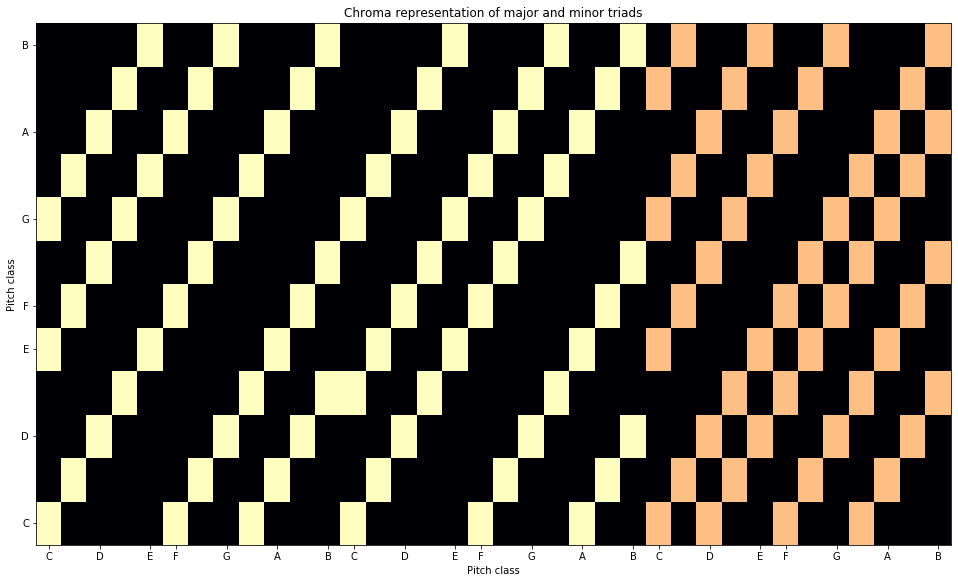

In [14]:
plt.figure(figsize=(16.4, 9.6))
g=dspl.specshow(chords, y_axis='chroma',x_axis='chroma')
#g=dspl.specshow(chords, y_axis='chroma',x_coords=chords_labs)
plt.title("Chroma representation of major and minor triads")

### Load audio file

In [15]:
from tkinter import filedialog
from tkinter import *

from librosa import *

import ntpath

In [16]:
# Select the file to analyze
root = Tk()
root.iconphoto(False, PhotoImage(file='play.png'))
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select an audio file",filetypes = (("all files","*.*"),("jpeg files","*.jpg")))
if(root.filename):
    #print ("Selected file path:",root.filename)
    name=ntpath.basename(root.filename)
    print ("Selected file name:",name)
else:
    print ("Please select a file!")
root.destroy()

Selected file name: Major_minor_triads_piano.wav


In [17]:
# loading file with librosa
#music,sr=load(root.filename,duration=60.0)
music,sr=load(root.filename)

# WARNING: You need to have ffmpeg insalled in order to open mp3 files
# If you are using conda/anaconda runnig the following in the command prompt should fix the problem:
# conda install -c conda-forge ffmpeg

print("Sampling rate:",sr)

Sampling rate: 22050


In [18]:
# I compress the piece of music, leaving no space for dynamics
#music=mu_compress(music, quantize=False, mu=10)

In [19]:
import matplotlib.pyplot as plt
import librosa.display as dspl

Text(0.5, 1.0, 'Opened music file: Major_minor_triads_piano.wav')

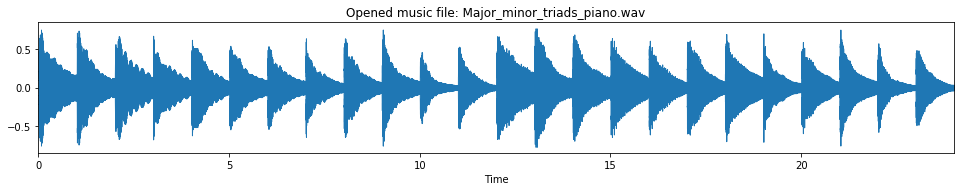

In [20]:
plt.figure(figsize=(16.4, 2.4))
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)

In [21]:
# Play oudio
import sounddevice as sd
sd.play(music, sr)

In [22]:
# Ok! Stop it!
sd.stop()

### Chromagram Computation

In [39]:
import librosa.feature as feat
# Parameters
n_fft=2048
hop_length=512*4


#chroma=feat.chroma_cens(y=music,sr=sr,norm=2,hop_length=hop_length,smoothing_window=10)
chroma=normalize_2(feat.chroma_stft(y=music,sr=sr,norm=2,hop_length=hop_length,n_fft=n_fft,tuning=0,octwidth=None))

In [40]:
import librosa

def temporal_smothing(chroma,n_win):
    chroma_sm=np.zeros(shape=chroma.shape)
    chr_pd=librosa.util.pad_center(chroma,chroma.shape[1]+n_win, axis=1)
    for n in range(chroma.shape[1]):
        chroma_sm[:,n]=np.sum(chr_pd[:,n:(n+n_win)],axis=1)*1/n_win
    return chroma_sm

chroma_smooth=temporal_smothing(chroma,n_win=20)

In [41]:
sum(chroma_smooth[:,50]**2)

0.5791764539640991

In [42]:
from librosa import mu_compress # this function is available only in recent versions of the package (for instance librosa 7.2)
chroma_compr = mu_compress(chroma_smooth, quantize=False, mu=30)
#chroma_compr = mu_compress(chroma, quantize=False, mu=10)

chroma_compr=normalize_2(chroma_compr)

In [43]:
sum(chroma_compr[:,100]**2)

1.0000000000000002

In [44]:
print(music.shape)
print(chroma.shape)
print(chroma_smooth.shape)

(529200,)
(12, 259)
(12, 259)


Text(0.5, 1.0, 'Smoothed and then compressed chroma representation of Major_minor_triads_piano.wav')

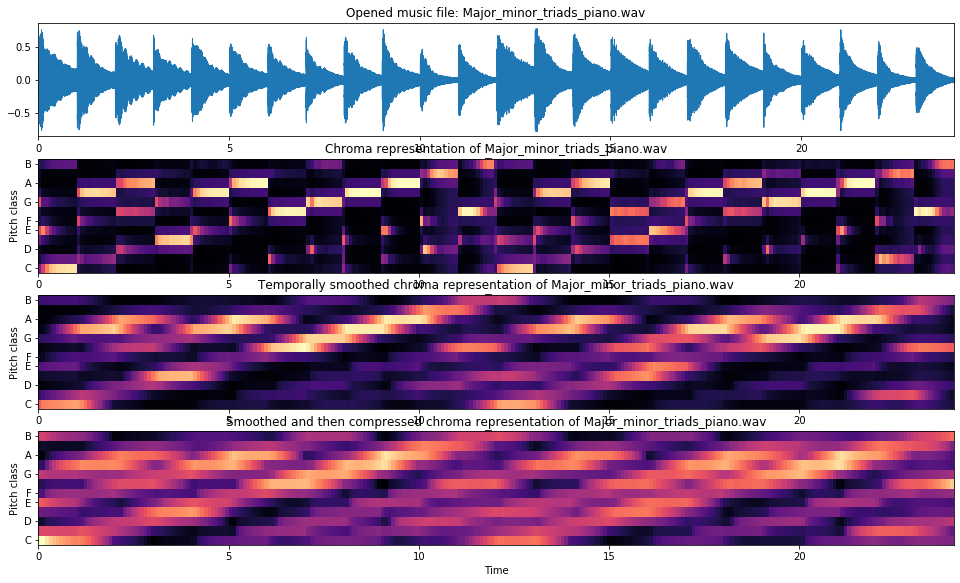

In [45]:
plt.figure(figsize=(16.4, 9.6))
plt.subplot(4,1,1)
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)
plt.subplot(4,1,2)
dspl.specshow(chroma, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Chroma representation of "+name)
plt.subplot(4,1,3)
dspl.specshow(chroma_smooth, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Temporally smoothed chroma representation of "+name)
plt.subplot(4,1,4)
dspl.specshow(chroma_compr, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Smoothed and then compressed chroma representation of "+name)

In [30]:
#frames_to_time(646, sr=sr, hop_length=hop_length, n_fft=n_fft)

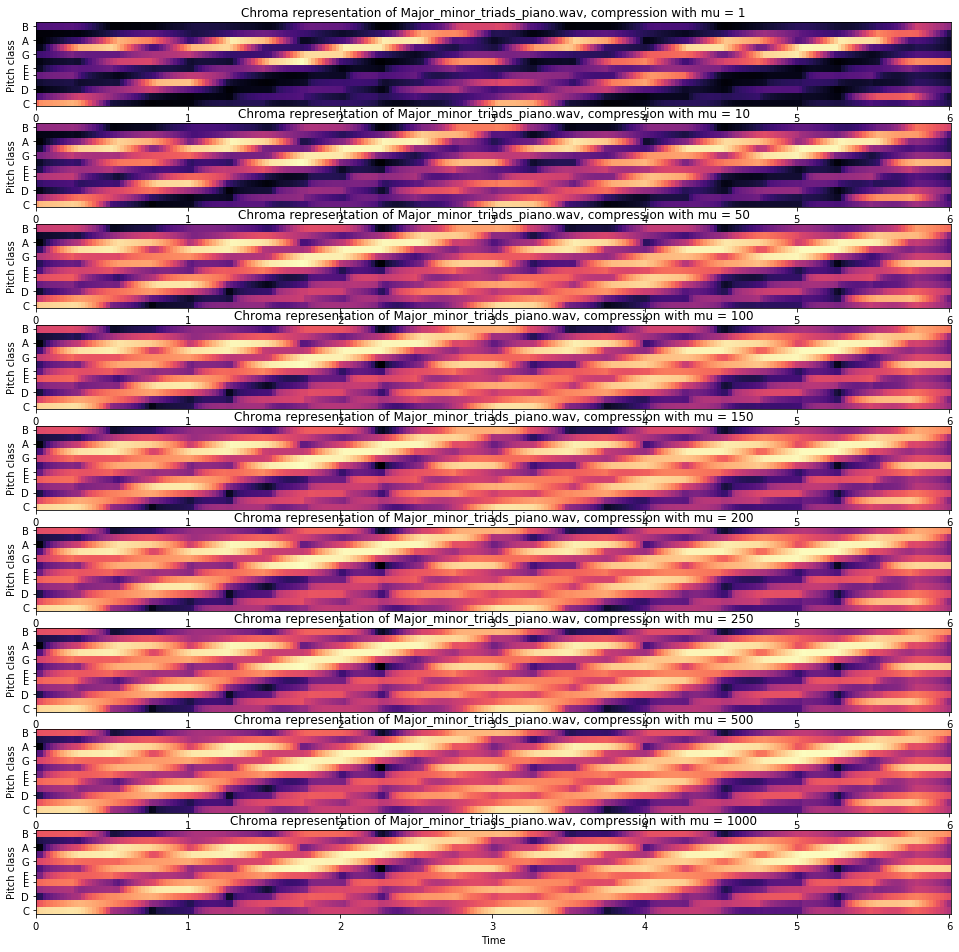

In [31]:
# The right parameter mu
plt.figure(figsize=(16.4, 16.4))
i=0
for mu in [1, 10, 50, 100, 150, 200, 250, 500, 1000]:
    i=i+1
    chroma_tmp = mu_compress(chroma_smooth,mu=mu, quantize=False)
    plt.subplot(9,1,i)
    dspl.specshow(chroma_tmp, y_axis='chroma', x_axis='time')
    plt.title("Chroma representation of "+name+", compression with mu = "+str(mu))

In [32]:
def template_matching(chroma,chords,chords_labs):
    nvals=chroma.shape[1]
    nchords=chords.shape[1]
    est_chords=np.zeros(shape=nvals,dtype=int)
    est_dist=np.zeros(shape=nvals)
    dist=np.zeros(shape=nchords)
    for i in range(nvals):
        for ch in range(nchords):
            dist[ch]=np.linalg.norm(chroma[:,i]-chords[:,ch])
            est_chords[i]=np.argmin(dist)
            est_dist[i]=np.min(dist)
        #print(str(i)+"\t"+str(frames_to_time(i, sr=sr, hop_length=hop_length, n_fft=n_fft))+"\t"+str(est_chords[i])+"\t"+chords_labs[est_chords[i]])
        #print(str(frames_to_time(i, sr=sr, hop_length=hop_length)),str(frames_to_time(i+1, sr=sr, hop_length=hop_length)),chords_labs[est_chords[i]])
        #if file != None:
        #    file.write(str(frames_to_time(i, sr=sr, hop_length=hop_length))+" "+str(frames_to_time(i+1, sr=sr, hop_length=hop_length))+" "+chords_labs[est_chords[i]]+"\n")
    return (est_chords,est_dist)

In [33]:
def write_lab_file(name,est_chords,sr,hop_length,chords_labs):
    #try:
        file = open("Analyzed_tracks/"+name+".lab","w")
        beg=0
        end=0
        curr=est_chords[0]
        N_chords=1
        for i in range(len(est_chords)):
            if est_chords[i] != curr:
                end=i
                file.write(str(frames_to_time(beg, sr=sr, hop_length=hop_length))+" "+str(frames_to_time(end, sr=sr, hop_length=hop_length))+" "+chords_labs[curr]+"\n")
                beg=i
                curr=est_chords[i]
                N_chords=N_chords+1
        end=len(est_chords)
        file.write(str(frames_to_time(beg, sr=sr, hop_length=hop_length))+" "+str(frames_to_time(end, sr=sr, hop_length=hop_length))+" "+chords_labs[curr]+"\n")
        file.close()
        #print(name+".lab"+" saved in \"Analyzed_tracks/\"")
        return N_chords
    #except:
    #    print("Something went wrong!")
    

In [34]:
estimated,distance=template_matching(chroma_compr,chords,chords_labs=chords_labs)
#estimated=template_matching(chroma_smooth,chords,chords_labs=triads_labs)
write_lab_file(name=name,est_chords=estimated,sr=sr,hop_length=hop_length,chords_labs=chords_labs)

44

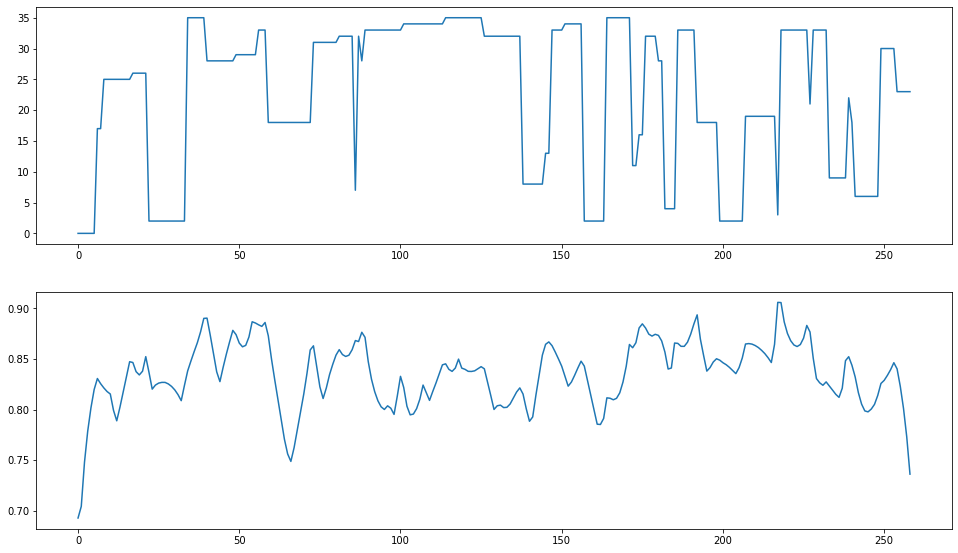

In [35]:
plt.figure(figsize=(16.4, 9.6))
plt.subplot(2,1,1)
plt.plot(estimated)
plt.subplot(2,1,2)
plt.plot(distance)

In [36]:
# Selection of parameters
N=20
avg_N_chords=np.zeros(shape=N,dtype=int)
for n in range(N):
    chroma_smooth=temporal_smothing(chroma,n_win=(n+1)*10)
    chroma_compr = mu_compress(chroma_smooth, quantize=False, mu=30)
    estimated=template_matching(chroma_compr,chords,chords_labs=chords_labs)
    #estimated=template_matching(chroma_smooth,chords,chords_labs=chords_labs)
    avg_N_chords[n]=write_lab_file(name="temp",est_chords=estimated,sr=sr,hop_length=hop_length,chords_labs=chords_labs)
    print(str((n+1)*10)+"\t"+str(avg_N_chords[n]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
avg_N_chords

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

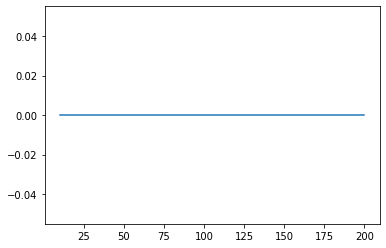

In [38]:
plt.plot([(n+1)*10 for n in range(N)],avg_N_chords)